## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов (вы уже встречались с ней во второй лабораторной работе) или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import time

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


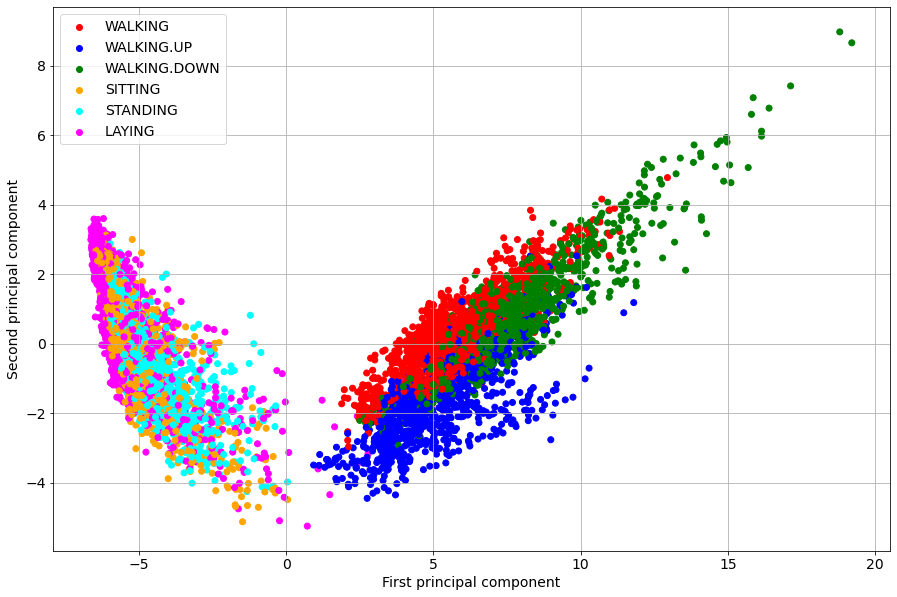

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: gdrive/My Drive/data/


In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


Подготовим DataLoaders

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torchsummary

In [ ]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
train_iter = iter(train_dataloader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
images shape on batch size = torch.Size([128, 128, 9])
labels shape on batch size = torch.Size([128, 1])


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda:0'

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch.squeeze(1))
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch.squeeze(1))

                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.squeeze(1).cpu() == y_pred.cpu()).numpy()))

        
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

    return train_loss, val_loss, val_accuracy

In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

###Experiment #1

In [ ]:
input_shape = 128*9
num_classes = 6

model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, input_shape//4),
            nn.ReLU(),
            nn.Linear(input_shape//4, num_classes),
            nn.LogSoftmax(dim=1)
        )

model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

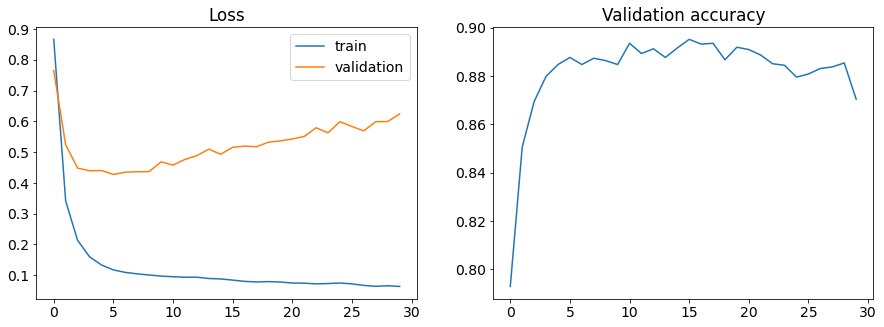

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
print("accuracy: ", val_accuracy[-1])

accuracy:  0.8704427083333334


Видим, что модель переобучилась, необходимо это исправить

###Experiment #2


In [ ]:
input_shape = 128*9
num_classes = 6

model = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(input_shape, input_shape//4),
            nn.ReLU(),
            nn.Linear(input_shape//4, num_classes),
            nn.LogSoftmax(dim=1)
        )

model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

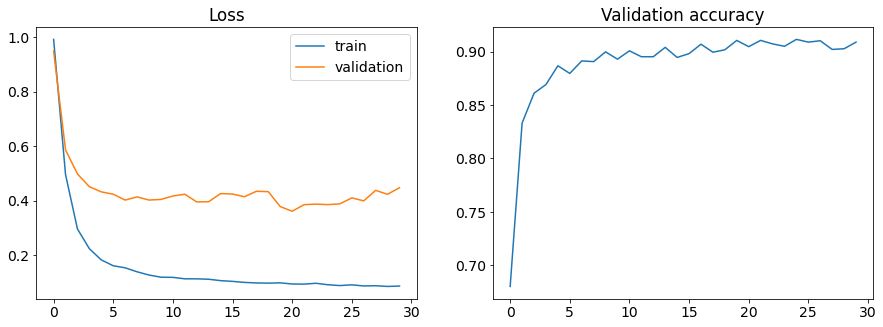

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
print("accuracy: ", val_accuracy[-1])

accuracy:  0.9088541666666666


###Experiment #3

In [ ]:
input_shape = 128*9
num_classes = 6

model = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(input_shape, input_shape//4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(input_shape//4, num_classes),
            nn.LogSoftmax(dim=1)
        )

model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

In [ ]:
n_epochs = 40

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

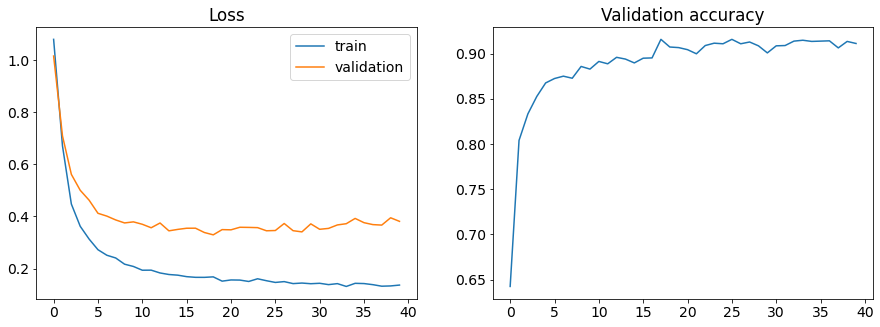

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
print("accuracy: ", val_accuracy[-1])

accuracy:  0.9111328125


Получили необходимый accuracy, но попытаемся выбить результат по-лучше

###Experiment #4

In [ ]:
input_shape = 128*9
num_classes = 6

model = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(input_shape, input_shape//2),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(input_shape//2, input_shape//4),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(input_shape//4, num_classes),
            nn.LogSoftmax(dim=1)
        )

model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

In [ ]:
n_epochs = 65

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

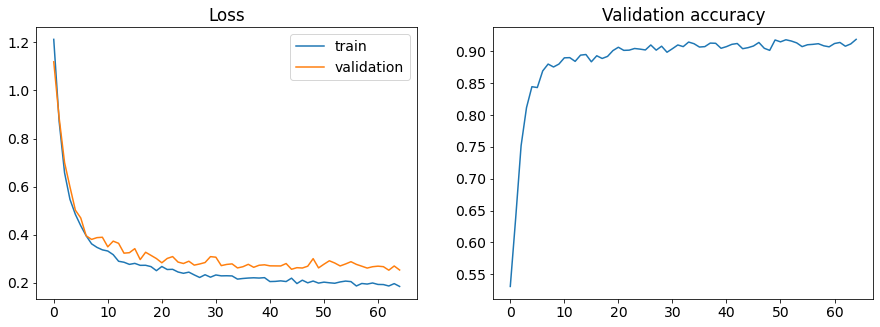

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
print("accuracy: ", val_accuracy[-1])

accuracy:  0.9182942708333334


###Experiment #5

In [ ]:
input_shape = 128*9
num_classes = 6

model = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(input_shape, input_shape*2),
            nn.BatchNorm1d(input_shape*2),
            nn.Sigmoid(),
            nn.Dropout(0.6),
            nn.Linear(input_shape*2, input_shape),
            nn.Sigmoid(),
            nn.Dropout(0.6),
            nn.Linear(input_shape, input_shape//2),
            nn.Sigmoid(),
            nn.Dropout(0.6),
            nn.Linear(input_shape//2, input_shape//4),
            nn.Sigmoid(),
            nn.Linear(input_shape//4, input_shape//8),
            nn.Sigmoid(),
            nn.Linear(input_shape//8, num_classes),
            nn.LogSoftmax(dim=1)
        )

model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

In [ ]:
n_epochs = 200

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

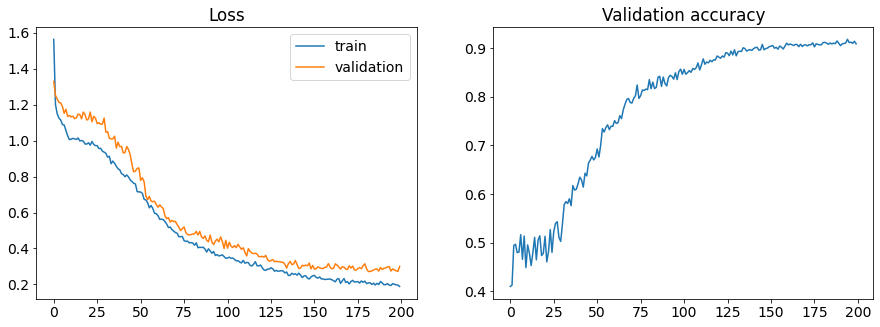

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
print("accuracy: ", val_accuracy[-1])

accuracy:  0.9085286458333334


###Experement #6

In [ ]:
input_shape = 128*9
num_classes = 6

model = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=9, stride=1, padding=0),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.7),
            nn.Linear(256,64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 12),
            nn.LeakyReLU(),
            nn.Linear(12, num_classes),
            nn.LogSoftmax(dim=1)
        )


model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

In [ ]:
n_epochs = 100

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

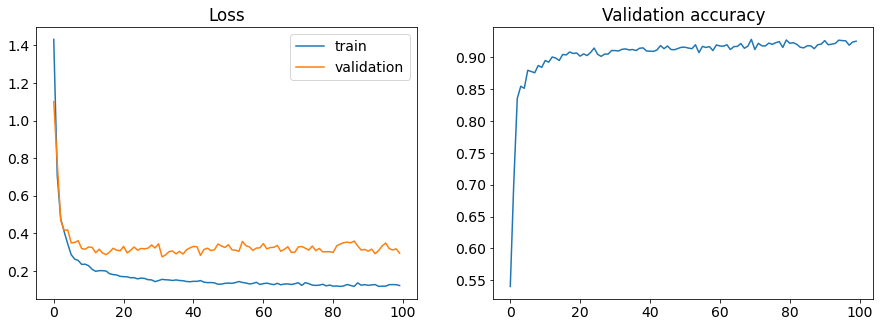

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
print("accuracy: ", val_accuracy[-1])

accuracy:  0.9251302083333334


###Experiment #7

In [ ]:
input_shape = 128*9
num_classes = 6

model = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=9, stride=1, padding=0),
            nn.BatchNorm1d(1024),
            nn.Sigmoid(),
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Sigmoid(),
            nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Dropout(0.7),
            nn.Linear(256,64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 12),
            nn.Sigmoid(),
            nn.Linear(12, num_classes),
            nn.LogSoftmax(dim=1)
        )


model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

In [ ]:
n_epochs = 300

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

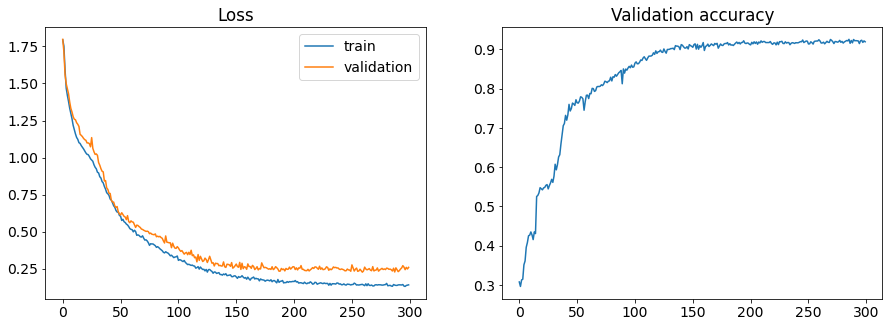

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
print("accuracy: ", val_accuracy[-1])

accuracy:  0.9189453125


### Вывод

Модели в эксперименте №4 и в эксперименте №6 показали наилучшую точность, а именно > 91%. Использовались два подхода: через линейные слои и через добавление к линейный Conv слоя. В целом, необходимый accuracy можно было добиться использовав только линейные слои с постепенным понижением фич и борьбой с переобучение. Когда я добилась нужной точности, я попробовала добавить conv слой, и в целом это дало прирост в точности порядка 1%. У меня получился результат в 92.5%

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import time

%matplotlib inline

import matplotlib
matplotlib.rcParams.update({'font.size':14})

from google.colab import drive
drive.mount('/content/gdrive')
PATH = "python/lab3/part4/"



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
DOGS_DATA = "gdrive/My Drive/" + PATH + "data/data/"
train_folders = DOGS_DATA + "train/"
test_folder = DOGS_DATA + "test/"

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torchsummary
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, TensorDataset, DataLoader, SubsetRandomSampler
from torch import Tensor
from PIL import Image
import os
from skimage import io, transform

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
classes = []
for c in range(50):
    for _ in os.listdir(train_folders + str(c)):
        classes.append(c)

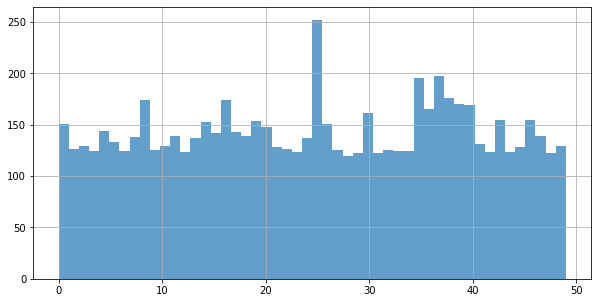

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(classes, bins=50, histtype='bar', alpha=0.7)
plt.grid()
plt.show()

Давайте разделим наши данные для обучения и тестирования, и передадим их предварительно обученной сети.

In [ ]:
train_transform = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


val_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [ ]:
train_data = torchvision.datasets.ImageFolder(root=train_folders,
                                            transform=train_transform)
val_data = torchvision.datasets.ImageFolder(root=train_folders,
                                            transform=val_transform)
N = len(classes)
indices = list(range(N))
split = int(0.2 * N)
np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=128, 
                                           sampler=train_sampler,
                                           num_workers=4)

val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=128, 
                                         sampler=val_sampler,
                                         num_workers=4)

In [ ]:
feature_extract = True
num_classes = 50

model = models.resnet101(pretrained=True)
print("layers:", [name for name, child in model.named_children()])

layers: ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


In [ ]:
for name, child in model.named_children():
    if name in ['fc']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is frozen
avgpool is frozen
fc is unfrozen


In [ ]:
in_features = model.fc.in_features
hidden_features = 640
model.fc = nn.Sequential(
    nn.Linear(in_features, hidden_features),
    nn.Dropout(),
    nn.BatchNorm1d(hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, 50)
)
input_size = 224
model = model.to(device)
loss_func = nn.CrossEntropyLoss().type(torch.FloatTensor)
opt = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.8)

In [ ]:
def train_model(model, train_loader, loss_fn, opt, val_loader=None,  n_epochs=70, scheduler=None):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)


            prediction = model.forward(X_batch)
            loss_value = loss_fn(prediction, y_batch)

            loss_value.backward()
            opt.step()

            ep_train_loss.append(loss_value.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model.forward(X_batch)
                loss_value = loss_fn(predictions, y_batch)

                ep_val_loss.append(loss_value.item())
                y_pred = predictions.max(-1).indices
                #print(y_pred.cpu(), y_batch.cpu())
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

        
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s val acc {np.mean(ep_val_accuracy)}')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        if scheduler:
            scheduler.step()

    return train_loss, val_loss, val_accuracy

def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [ ]:
n_epochs = 20

train_loss, val_loss, val_accuracy = train_model(model, train_loader, loss_func, opt, val_loader=val_loader, n_epochs=n_epochs, scheduler=None)

Epoch 1 of 20 took 47.430s val acc 0.9047916666666667
Epoch 2 of 20 took 47.547s val acc 0.9140625
Epoch 3 of 20 took 47.653s val acc 0.9060156250000001
Epoch 4 of 20 took 47.241s val acc 0.9172395833333334
Epoch 5 of 20 took 47.681s val acc 0.915859375
Epoch 6 of 20 took 48.086s val acc 0.9315625000000001
Epoch 7 of 20 took 48.276s val acc 0.9185416666666667
Epoch 8 of 20 took 47.914s val acc 0.9157812500000001
Epoch 9 of 20 took 47.594s val acc 0.9249739583333333
Epoch 10 of 20 took 47.776s val acc 0.9230208333333333
Epoch 11 of 20 took 47.608s val acc 0.931640625
Epoch 12 of 20 took 47.993s val acc 0.9165104166666667
Epoch 13 of 20 took 47.596s val acc 0.9322135416666667
Epoch 14 of 20 took 47.701s val acc 0.9148958333333334
Epoch 15 of 20 took 47.630s val acc 0.9261979166666667
Epoch 16 of 20 took 47.750s val acc 0.925625
Epoch 17 of 20 took 47.663s val acc 0.9230208333333333
Epoch 18 of 20 took 47.687s val acc 0.9309114583333334
Epoch 19 of 20 took 48.193s val acc 0.92432291666666

accuracy:  0.9203385416666667


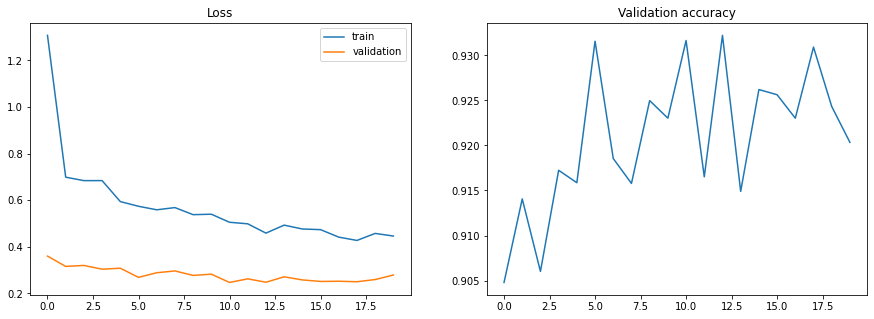

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)
print("accuracy: ", val_accuracy[-1])

In [ ]:
n_epochs = 5

train_loss, val_loss, val_accuracy = train_model(model, train_loader, loss_func, opt, val_loader=val_loader, n_epochs=n_epochs, scheduler=None)

Epoch 1 of 5 took 47.878s val acc 0.9361979166666666
Epoch 2 of 5 took 47.964s val acc 0.9328645833333334
Epoch 3 of 5 took 49.587s val acc 0.931484375
Epoch 4 of 5 took 49.667s val acc 0.9335156250000001
Epoch 5 of 5 took 49.594s val acc 0.9301822916666667


accuracy:  0.9301822916666667


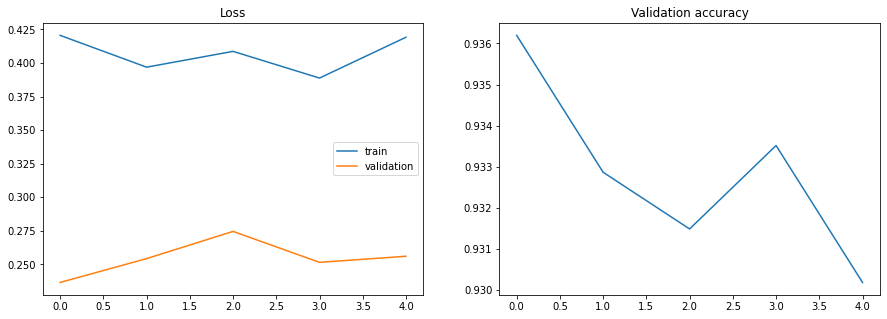

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)
print("accuracy: ", val_accuracy[-1])

Взяв resnet101, получилась необходимая точность.
Я также пробовала разные планировщики, но этот вариант работал лучше всего.

In [ ]:
class DogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.len = max(int(file[:-5]) for file in os.listdir(root_dir) if file[:-5].isnumeric()) + 1

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = Image.open(rf"{self.root_dir}/{idx}.jpeg")
        if self.transform:
            image = self.transform(image)
        return image, idx

In [ ]:
test_dataset = DogsDataset(root_dir=test_folder, transform=train_transform)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128, 
                                          num_workers=4)

In [ ]:
preds = []
idxs = []
model.train(False)
with torch.no_grad():
    for data in test_loader:
        image, idx = data
        image = image.to(device)
        idxs.extend(idx)
        preds.extend(model(image).cpu().detach().numpy().tolist())

In [ ]:
idxs_list = [idx.item() for idx in idxs]
preds = np.array(preds)
predictions = pd.DataFrame()
predictions["photo"] = idxs_list
predictions["pred"] = np.argmax(preds, axis=1)

In [ ]:
predictions.to_csv("gdrive/My Drive/" + PATH + "test.csv")